In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pd.set_option('max_rows', 500)
pd.set_option('display.max_columns', 300)
np.random.seed(666)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.5f}'.format)
pd.set_option('display.max_colwidth', None)

In [2]:
TARGET_COL = 'diabetes_mellitus'
cat_cols = ['ethnicity','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type',
            'age_group','demo_profile','apache_3j_group','a1c_bp_group',
            'apache_2_diagnosis','icu_id']

def target_encode(var, dv, weight = 36):
    mean = dv.mean()
    true_weight = weight * max(1, mean/(1-mean))
    agg = dv.groupby(var,dropna=False).agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    return (counts * means + true_weight) / (counts + true_weight/mean)

def target_encode_train_test(var_train, dv_train, var_test, weight = 36):
    encode_key = target_encode(var_train,dv_train,weight)
    return var_train.map(encode_key), var_test.map(encode_key).astype(np.float32).fillna(dv_train.mean())

In [3]:
train = pd.read_csv('Data/train_FE2_filter4.csv')
test = pd.read_csv('Data/test_FE2_filter4.csv')

In [4]:
features_to_ignore = ['encounter_id','hospital_id','apache_3j_diagnosis']
vars_to_encode = ['icu_id','apache_3j_diagnosis','demo_profile']
for col in vars_to_encode:
    train[col+'_encoded'], test[col+'_encoded'] = target_encode_train_test(
        train[col],train[TARGET_COL],test[col])

In [6]:
combined = pd.concat([train.drop(TARGET_COL,axis=1), test], ignore_index=True).drop(cat_cols+features_to_ignore,axis=1)
# str_cols = ['icu_id','apache_2_diagnosis']
# combined[str_cols] = combined[str_cols].astype(str)
# combined[cat_cols] = combined[cat_cols].fillna('')
#combined[cat_cols] = combined[cat_cols].astype('category')

In [7]:
imp_median = SimpleImputer(strategy='median').fit(combined)
combined = pd.DataFrame(imp_median.transform(combined), index=combined.index, columns = combined.columns)

In [8]:
# corrs_spearman = combined.rank().corr()
# corrs_spearman.to_csv('corrs_spearman.csv')
corrs_spearman = pd.read_csv('corrs_spearman.csv')
corrs_spearman.index = corrs_spearman['Unnamed: 0']
corrs_spearman.drop('Unnamed: 0',axis=1,inplace=True)
corrs_spearman = corrs_spearman.loc[combined.columns,combined.columns]

In [9]:
corrs_spearman.shape

(562, 562)

In [ ]:
vars_to_inspect = ['bilirubin_apache','d1_bilirubin_max','d1_bilirubin_min']
corrs_spearman.loc[vars_to_inspect,vars_to_inspect]

In [ ]:
corrs = np.abs(corrs_spearman)

In [ ]:
high_corrs_dict = {}
corr_list = []
for index, row in corrs.iterrows():
    corr_vars = list(row.index[row > .95])
    if index in corr_vars:
        corr_vars.remove(index)
    if corr_vars:
        high_corrs_dict[index] = corr_vars
        corr_list.append(index)

In [ ]:
high_corrs_dict

In [10]:
corrs_non_na = corrs_spearman.dropna(axis=0,how='all').dropna(axis=1,how='all')

In [11]:
corrs_dist = np.sqrt((1-np.abs(np.array(corrs_non_na))))

In [12]:
# corr_linkage = hierarchy.ward(corrs_dist[np.triu_indices(corrs_dist.shape[0])])
ward_linkage = hierarchy.ward(squareform(corrs_dist))
mean_linkage = hierarchy.average(squareform(corrs_dist))
single_linkage = hierarchy.single(squareform(corrs_dist))
complete_linkage = hierarchy.complete(squareform(corrs_dist))
weighted_linkage = hierarchy.weighted(squareform(corrs_dist))
centroid_linkage = hierarchy.centroid(squareform(corrs_dist))
median_linkage = hierarchy.median(squareform(corrs_dist))

In [13]:
print('Ward cophenetic = ',hierarchy.cophenet(ward_linkage, squareform(corrs_dist)))
print('Mean cophenetic = ',hierarchy.cophenet(mean_linkage, squareform(corrs_dist)))
print('Single cophenetic = ',hierarchy.cophenet(single_linkage, squareform(corrs_dist)))
print('Complete cophenetic = ',hierarchy.cophenet(complete_linkage, squareform(corrs_dist)))
print('Weighted cophenetic = ',hierarchy.cophenet(weighted_linkage, squareform(corrs_dist)))
print('Centroid cophenetic = ',hierarchy.cophenet(centroid_linkage, squareform(corrs_dist)))
print('Median cophenetic = ',hierarchy.cophenet(median_linkage, squareform(corrs_dist)))

Ward cophenetic =  (0.36642251405611975, array([2.85306916, 3.96144968, 3.96144968, ..., 3.84958242, 3.96144968,
       3.96144968]))
Mean cophenetic =  (0.9016512141486301, array([0.89482995, 0.89482995, 0.98233024, ..., 0.98502118, 0.98502118,
       0.98164537]))
Single cophenetic =  (0.6972745530449925, array([0.60248792, 0.74945482, 0.87004648, ..., 0.91173679, 0.91173679,
       0.80614989]))
Complete cophenetic =  (0.8279194253751017, array([0.999982  , 0.99857645, 0.999982  , ..., 1.        , 1.        ,
       0.999982  ]))
Weighted cophenetic =  (0.8805125489026302, array([0.85239092, 0.89648187, 0.99386642, ..., 0.98834505, 0.99386642,
       0.99386642]))
Centroid cophenetic =  (0.589750634608529, array([0.61845396, 0.70483788, 0.70182855, ..., 0.71120409, 0.71120409,
       0.67523076]))
Median cophenetic =  (0.43658116479092834, array([0.5872312 , 0.74900301, 0.67284049, ..., 0.78848447, 0.78848447,
       0.5607827 ]))


In [14]:
silhouette_scores = []
for n_clust in np.linspace(2,561,560):
    clusters = hierarchy.fcluster(mean_linkage, t=n_clust, criterion='maxclust')
    silhouette = silhouette_score(corrs_dist, clusters, metric='precomputed')
    silhouette_scores.append({'n_cluster':n_clust,'silhouette':silhouette})
silhouette_df = pd.DataFrame(silhouette_scores)

<AxesSubplot:xlabel='n_cluster', ylabel='silhouette'>

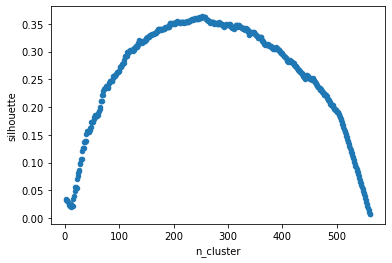

In [15]:
silhouette_df.plot.scatter(x='n_cluster',y='silhouette')

In [ ]:
silhouette_df.to_csv('silhouette_score.csv',index=False)

In [41]:
silhouette_df.n_cluster[silhouette_df.silhouette == silhouette_df.silhouette.max()]

251              253.00000
Name: n_cluster, dtype: float64

In [42]:
silhouette_df.silhouette.max()

0.3639275376811761

In [51]:
clusters = hierarchy.fcluster(mean_linkage, t=.547, criterion='distance')
# 514=.4293
# 452=.4975

In [52]:
silhouette_score(corrs_dist, clusters, metric='precomputed')

0.3639275376811761

In [53]:
cluster_df = pd.DataFrame({'feature':corrs_non_na.columns,'cluster':clusters})

In [54]:
cluster_df.sort_values('cluster')

,feature,cluster
76,heartrate_d1_max_min_switched,1
77,potassium_any_max_min_switched,2
149,temp_any_h1_more_extreme,3
151,temp_d1_h1_range_ratio,4
455,demo_profile_sodium_d1_avg_mean_ratio,5
...,...,...
10,gcs_unable_apache,249
73,aids,250
191,glucose_min_h1_more_extreme,251
94,h1_sysbp_diasbp_noninvasive_max_diff_0_or_less,252


In [55]:
perm_importances = pd.read_csv('perm_importances.csv')
perm_importances.rename(columns={'Unnamed: 0':'feature'},inplace=True)

In [56]:
loss_function_changes = pd.read_csv('loss_function_changes.csv')

In [57]:
pred_value_changes = pd.read_csv('pred_value_changes.csv')

In [58]:
cluster_df.merge(
    perm_importances[['feature','PI_mean','PI_SD','PI_Zscore']],on='feature',how='right').merge(
    loss_function_changes[['feature','LFC_mean','LFC_SD','LFC_Zscore']],on='feature').merge(
    pred_value_changes[['feature','PVC_mean','PVC_SD','PVC_Zscore']],on='feature').to_csv(
    'clusters253_with_importances.csv',index=False)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 80))
dendro = hierarchy.dendrogram(
    mean_linkage, labels=corrs_non_na.columns, ax=ax1, leaf_rotation=90
)

In [ ]:
scaler = StandardScaler().fit(combined)
combined_scaled = scaler.transform(combined)
pca = PCA().fit(combined_scaled)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
(np.cumsum(pca.explained_variance_ratio_) < .99).sum()

In [ ]:
# d1_glucose_max (+0), glucose_apache (+.00001)
# glucose_d1_max_min_diff (-.00023), glucose_d1_max_min_ratio (-.00034)
# apache_3j_diagnosis, apache_2_diagnosis
# d1_wbc_max, d1_wbc_min
# d1_creatine_min, creatinine_apache
# h1_glucose_min, h1_glucose_max